In [17]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [18]:
from tensorflow.keras.datasets import mnist
from tensorflow.data import Dataset
from tensorflow import random


In [19]:
from tensorflow.keras import Sequential

In [20]:
import pickle

## Reloading preprocessed picture

In [21]:
DATA_PREPROC = "/Users/ombelinemichallet/code/35m5loKiUe/LeWaGAN/raw_data/preproc/"

In [22]:
size=64

In [23]:
BUFFER_SIZE = 20000
BATCH_SIZE = 256

In [24]:
def load_preprocessing(location):
    with open(os.path.join(location, f'dataset_manga{size}'),'rb') as file :
            preproc_data = pickle.load(file)
    return preproc_data

In [25]:
training_data = load_preprocessing(DATA_PREPROC)

In [26]:
training_data = training_data[:20000].shape

In [27]:
# Batch and shuffle the data
train_dataset = Dataset.from_tensor_slices(load_preprocessing(DATA_PREPROC)[:20000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Test with a very simplistic generator

In [28]:
def make_generator_model():
    model = Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(None, 64, 64, 32)


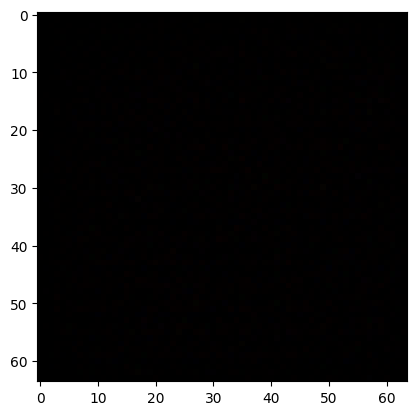

In [29]:
generator = make_generator_model()

noise = random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

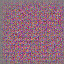

In [30]:
from tensorflow.keras.preprocessing import image
image.array_to_img(np.squeeze(generated_image))

## we keep same discriminator and optimization functions

In [31]:
def make_discriminator_model():
    model = Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation= tf.nn.relu))
    model.add(layers.Dense(1))

    return model

In [32]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00026643]], shape=(1, 1), dtype=float32)


In [33]:
from tensorflow.keras import losses

In [34]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

In [35]:
from tensorflow import ones_like, zeros_like

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(ones_like(real_output), real_output)
    fake_loss = cross_entropy(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(ones_like(fake_output), fake_output)

In [38]:
from tensorflow.keras import optimizers

In [39]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [40]:
from tensorflow.train import Checkpoint

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [42]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = random.normal([num_examples_to_generate, noise_dim])

In [43]:
from tensorflow import GradientTape

In [44]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = random.normal([BATCH_SIZE, noise_dim])

    with GradientTape() as gen_tape, GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [45]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [46]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      #im2display = predictions[i].transpose((1,2,0))
      plt.imshow(predictions[i, :, :, :], interpolation='nearest')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

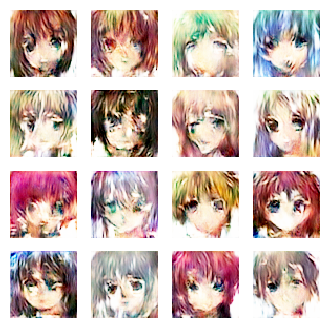

Time for epoch 5 is 39.198864221572876 sec


KeyboardInterrupt: 

In [48]:
train(train_dataset, EPOCHS)

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [102]:
print(generator.trainable_variables[0].numpy())

[[ 0.01098301 -0.01383979  0.00817808 ...  0.02379352 -0.00536683
  -0.10440281]
 [-0.00759454  0.04150585 -0.00468444 ...  0.07641988  0.10064628
   0.04317857]
 [ 0.00397339 -0.11198541 -0.03836923 ...  0.06726927  0.07673854
   0.0001563 ]
 ...
 [ 0.06188455  0.04853996 -0.00977135 ...  0.02529966  0.02767204
  -0.04628718]
 [ 0.04455099 -0.10429044 -0.04349156 ... -0.02627119 -0.01717742
   0.01056284]
 [ 0.03253102  0.00835375  0.00643801 ...  0.08173651  0.04527165
   0.05891402]]


In [103]:
A = generator.trainable_variables[0].numpy()

In [105]:
A_T = A.T

In [112]:
AA_T = np.dot(A, A_T)

In [113]:
AA_T.shape

(100, 100)

In [166]:
tt = np.linalg.eig(AA_T)

In [203]:
tt[0]

array([105.05642 , 101.54739 ,  99.40612 , 100.14051 ,  24.201672,
        25.29168 ,  27.335691,  28.623135,  30.35582 ,  32.462795,
        32.95096 ,  96.67005 ,  95.670334,  95.18153 ,  93.91081 ,
        92.88382 ,  91.626816,  33.923935,  90.08901 ,  34.968548,
        35.651608,  36.43287 ,  37.084072,  88.69975 ,  88.351585,
        87.32211 ,  86.034225,  38.361828,  85.119354,  38.75266 ,
        39.26769 ,  40.127377,  41.579197,  84.337296,  83.29164 ,
        83.10462 ,  82.65914 ,  42.773933,  42.656258,  43.59729 ,
        43.367393,  81.39412 ,  81.3024  ,  80.8259  ,  80.31485 ,
        79.68053 ,  79.21644 ,  45.47522 ,  45.803783,  46.03254 ,
        78.53895 ,  47.343563,  77.238174,  77.02734 ,  48.051384,
        48.277924,  75.95806 ,  75.350464,  48.63425 ,  49.72474 ,
        49.493813,  74.74451 ,  74.237976,  73.73897 ,  51.07378 ,
        51.528587,  72.75266 ,  72.197495,  71.30757 ,  52.809353,
        52.847008,  70.82818 ,  53.905956,  54.056847,  68.575

In [204]:
test = tt[1][0]
test2 = tt[1][1]
test3 = tt[1][2]

In [159]:
print(tt[1].shape)

(100, 100)


In [83]:
generator.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(100, 16384) dtype=float32, numpy=
 array([[ 0.01098301, -0.01383979,  0.00817808, ...,  0.02379352,
         -0.00536683, -0.10440281],
        [-0.00759454,  0.04150585, -0.00468444, ...,  0.07641988,
          0.10064628,  0.04317857],
        [ 0.00397339, -0.11198541, -0.03836923, ...,  0.06726927,
          0.07673854,  0.0001563 ],
        ...,
        [ 0.06188455,  0.04853996, -0.00977135, ...,  0.02529966,
          0.02767204, -0.04628718],
        [ 0.04455099, -0.10429044, -0.04349156, ..., -0.02627119,
         -0.01717742,  0.01056284],
        [ 0.03253102,  0.00835375,  0.00643801, ...,  0.08173651,
          0.04527165,  0.05891402]], dtype=float32)>,
 <tf.Variable 'batch_normalization_4/gamma:0' shape=(16384,) dtype=float32, numpy=
 array([1.1926839, 1.2373793, 1.1201792, ..., 1.2837713, 0.9474075,
        1.3113976], dtype=float32)>,
 <tf.Variable 'batch_normalization_4/beta:0' shape=(16384,) dtype=float32, numpy=
 array([-0.09

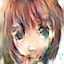

In [192]:
image.array_to_img(np.squeeze(generator(noise+test)))

In [217]:
predict = []
for i in np.linspace(0,10,num=16):
    predict.append(np.squeeze(generator(noise+i*test)))

In [210]:
np.linspace(0,1,num=16)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

In [198]:
len(predict)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

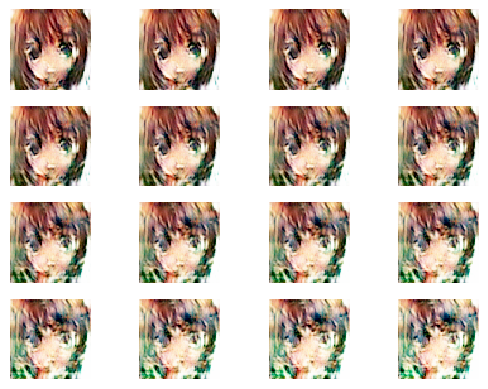

In [218]:
for i in range(len(predict)):
      plt.subplot(4, 4, i+1)
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      #im2display = predictions[i].transpose((1,2,0))
      plt.imshow(predict[i], interpolation='nearest')
      plt.axis('off')